In [1]:
import torch
import matplotlib.pyplot as plt

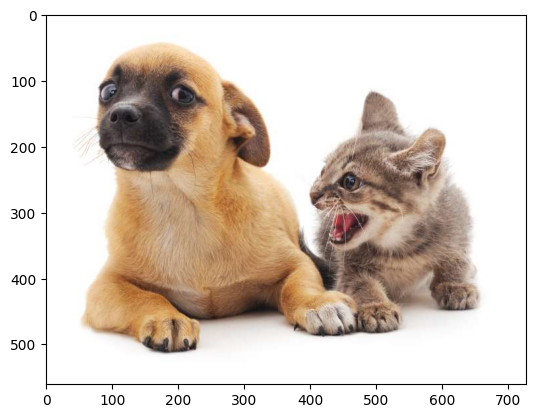

In [2]:
img = plt.imread("./catdog.jpg")
plt.imshow(img)

In [3]:
def box_corner_to_center(boxs):
    x1 , y1 , x2 ,y2 = boxs[:,0:1],boxs[:,1:2],boxs[:,2:3],boxs[:,3:]
    cx = (x1 + x2)/2
    cy = (y1 + y2)/2
    w = x2 - x1
    h = y2 - y1
    
    return torch.concat((cx,cy,w,h),dim=1)
def box_center_to_corner(boxs):
    cx,cy,w,h = boxs[:,0:1],boxs[:,1:2],boxs[:,2:3],boxs[:,3:]
    x1 = cx - w * 0.5
    y1 = cy - h * 0.5
    x2 = cx + w * 0.5
    y2 = cy + h * 0.5

    return torch.concat((x1,y1,x2,y2),dim=1)

In [4]:
# bbox是边界框的英文缩写
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]
boxes = torch.tensor((dog_bbox, cat_bbox))

box_center_to_corner(box_corner_to_center(boxes)) == boxes


tensor([[True, True, True, True],
        [True, True, True, True]])

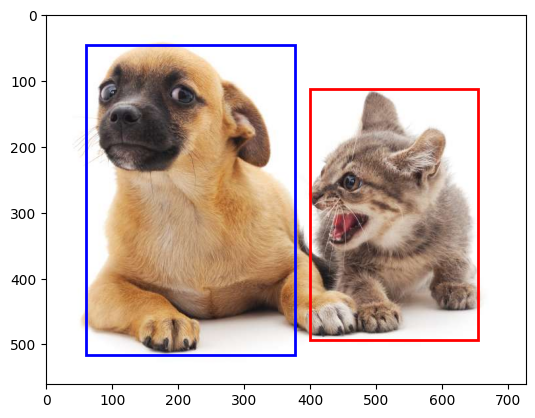

In [5]:
def bbox_to_rect(bbox,color):
    
    return plt.Rectangle(
        xy=(bbox[0],bbox[1]),
        width=bbox[2] - bbox[0],
        height=bbox[3]-bbox[1],
        fill = False,
        edgecolor = color,
        linewidth = 2 
    )
fig = plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox,"blue"))
fig.axes.add_patch(bbox_to_rect(cat_bbox,"red"))


In [6]:
def multibox_prioe(data,sizes,ratios):
    in_heigjt , in_width = data.shape[-2:]
    device ,num_size ,num_ratios = data.device,len(sizes),len(ratios)
    boxes_per_pixel = (num_size + num_ratios - 1)
    size_tensor = torch.tensor(sizes,device=device)
    ratios_tensor = torch.tensor(ratios,device=device)

    offset_h,offset_w = 0.5,0.5
    #设置中心点偏移

    steps_h = 1.0/in_heigjt
    steps_w = 1.0/in_width
    #计算相对比例
    center_h = (torch.arange(in_heigjt,device=device) + offset_h )*steps_h
    center_w = (torch.arange(in_width,device=device) + offset_w)*steps_w
    #遍历每一个像素点
    shift_y,shift_x = torch.meshgrid(center_h,center_w,indexing='ij')
    #“ij”产生shape为yx的矩阵，先是dim=0全部以y填充，然后填充x次，然后是dim=1
    #上以x填充填充y次
    print("shift_y",shift_y.shape)
    print("shift_x",shift_x.shape)
    shift_y = shift_y.reshape(-1)
    shift_x = shift_x.reshape(-1)
    #拉直
    print(shift_x.shape)

    w = torch.cat((size_tensor * torch.sqrt(ratios_tensor[0]),
                   sizes[0]*torch.sqrt(ratios_tensor[1:])))*in_heigjt /in_width
    #将所有可能的计算情况形成一个矩阵 由于在归于系里面设置比例
    h = torch.cat(
        (size_tensor / torch.sqrt(ratios_tensor[0]),
        size_tensor[0] / torch.sqrt(ratios_tensor[1:]))
    )
    print(w.shape)
    anchor_manipu = torch.stack(
        (-w,-h,w,h)).T.repeat(in_heigjt * in_width,1)/2
    
    #dim=0 stack形成shape为4,5,然后转置为5,4,然后复制m次在dim=0上
    #这个时候 dim=0 的维度为5 * m 其中5说明所有情况为了符合每一个像素点都可以
    #经历5次变化 所以复制m次
    print(anchor_manipu.shape)
    out_grid = torch.stack(
        [shift_x,shift_y,shift_x,shift_y],
        dim=1
    ).repeat_interleave(boxes_per_pixel,dim=0)
    #在dim=1上堆积 shape为m ， 4,然后在dim=0按元素复制一定次数
    #为的是和anchor 对齐  由于按照元素相对于在dim=0上每连续5个是相同的
    #这样刚好和上面对应 实现一个x可以产生5个情况
    #一共有m个x ，则生产m * 5个数据 在dim=0
    output = out_grid + anchor_manipu 
    return output.unsqueeze(0)

img = plt.imread('catdog.jpg')
h, w = img.shape[:2]

print(h, w)
X = torch.rand(size=(1, 3, h, w))
Y = multibox_prioe(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape
Y = Y.reshape((-1,4))
Y.shape



561 728
shift_y torch.Size([561, 728])
shift_x torch.Size([561, 728])
torch.Size([408408])
torch.Size([5])
torch.Size([2042040, 4])


torch.Size([2042040, 4])

In [7]:
boxes = Y.reshape(h, w, 5, 4)


In [8]:
def show_bboxes(axes,bboxes,label=None,colors=None):
    def make_list(obj,default_values=None):
        if obj is None:
            return default_values
        elif not isinstance(obj,(list,tuple)):
            obj = [obj]
        return obj
    labels = make_list(label)
    colors = make_list(colors,['b', 'g', 'r', 'm', 'c'])

    for i ,bbox in enumerate(bboxes):
        color = colors[i%len(colors)]
        rect = bbox_to_rect(bbox.detach().numpy(),color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))
        

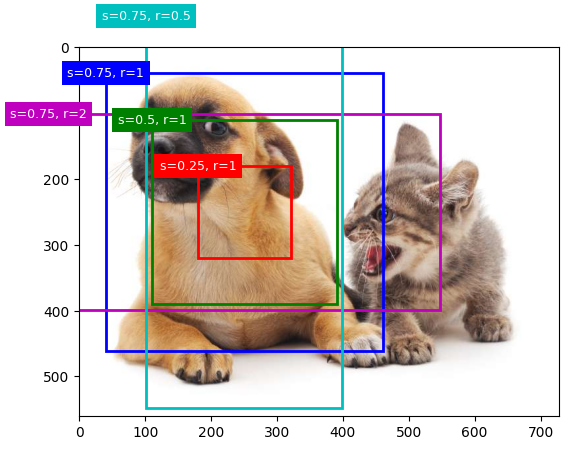

In [9]:
bbox_scale = torch.tensor((w, h, w, h))
fig = plt.imshow(img)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
            label=['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
             's=0.75, r=0.5'])

In [ ]:
def box_iou(box1,box2):
    box_are = lambda boxs: ((boxs[:,2] - boxs[:,0]) * (boxs[:,3] - boxs[:,1]))

    areas1 = box_are(box1)
    areas2 = box_are(box2)

    # (boxes1的数量,boxes2的数量,2)
    inter_upperlefts = torch.max(box1[:, None, :2], box2[:, :2])
    inter_lowerrights = torch.min(box1[:, None, 2:], box2[:, 2:])
    #box1[:,None,:2]利用广播机制实现维度扩展 
    #对于全局的情况的遍历
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    # inter_areasandunion_areas的形状:(boxes1的数量,boxes2的数量)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

result = box_iou(boxes[250,250,:,:],boxes[250,251,:,:])
result.shape,Y.shape

(torch.Size([5, 5]), torch.Size([2042040, 4]))

In [11]:
def assgin_achor_to_bbox(groud_truth,anchors,device,iou_threshold=0.5):
    """
    其中 groud_truth 为真实的label
    anchors 为锚框
    """
    num_achors,num_gt_bboxes = anchors.shape[0],groud_truth.shape[0]
    #先获取锚框和实际label的数量
    #方便建立联写
    jaccard = box_iou(anchors,groud_truth)
    #计算锚框和labels的jaccard指数 方便作为产考建立联系
    anchors_bbox_map = torch.full((num_achors,),
                                  -1,
                                  dtype=torch.long,
                                  device=device)
    #先建立映射表 对于部分的锚框设定关联

    
    max_ious , indices = torch.max(jaccard,dim=1)
    #选却每一行的最大的jaccard指数和其index
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
    #对于超过阈值的部分提取其对应的index

    box_j = indices[max_ious >= iou_threshold]
    #box_j 为对应的关联标签  这里的bool掩码可以换成anc_i
    anchors_bbox_map[anc_i] = box_j
    #修改映射表里面的参数信息
    col_discard = torch.full((num_achors,), -1)
    row_discard = torch.full((num_gt_bboxes,), -1)
    #设定清除数组

    for _ in range(num_gt_bboxes):#防止存在label没有对应的锚框的情况
        max_idx = torch.argmax(jaccard)
        #选取全局最大的jaccard
        box_idx = (max_idx % num_gt_bboxes).long()
        #获得对应的label 即列标
        anc_idx = (max_idx / num_gt_bboxes).long()
        #获得对应的锚框 即行标
        anchors_bbox_map[anc_idx] = box_idx
        #修改映射表里面的数值
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
        #清除信息
    return anchors_bbox_map

   

In [12]:
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """
    eps 代表的是为了防止log炸掉设置的小数字
    """
    c_anc = box_corner_to_center(anchors)
    c_ass_bb = box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_ass_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_ass_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset


In [13]:
def multibox_target(anchors,labels):
    batch_size  , anchors = labels.shape[0] , anchors.squeeze(0)
    batch_offset , batch_mask , batch_class_label = [],[],[]
    device , num_anchor = anchors.device , anchors.shape[0]
    
    for i in range(batch_size):
        label = labels[i,:,:]
        anchors_bbox_map = assgin_achor_to_bbox(
                                label[:,1:],anchors,device
                                )
        #(num_achor,)
        bbox_mask = ((anchors_bbox_map>=0).float().unsqueeze(-1)).repeat(1,4)
        #(num_anchor,4)
        class_labels = torch.zeros(num_anchor,dtype=torch.long,device=device)
        #(num_anchor,)
        assigned_bb = torch.zeros((num_anchor,4),dtype=torch.float32,device=device)
        #(num_anchor.4)
        indices_true = torch.nonzero(anchors_bbox_map>=0)
        #(num_anchor,)
        bb_idx = anchors_bbox_map[indices_true]

        class_labels[indices_true] = label[bb_idx,0].long() + 1
        #转化为真实索引
        #由于anchor_bbox_map 统一使用0,1,2.....来表示种类 但是实际上可能不是相同的可能是从1开始
        assigned_bb[indices_true] = label[bb_idx,1:]
        #获得存在的坐标情况
        #将非背景框对应的框的坐标数值存储
        offset = offset_boxes(anchors , assigned_bb) * bbox_mask
        #计算锚框和真实标签的偏移差距
        #这里乘上mask是存在必要的
        #根本目的是为了消除掉在计算时候出现的Nan问题
        batch_offset.append(offset.reshape(-1))  # (num_anchors×4,)
        batch_mask.append(bbox_mask.reshape(-1))  # (num_anchors×4,)
        batch_class_label.append(class_labels)    # (num_anchors,)
        #将数据存储到list中 然后实现张量的拼接
        
    bbox_offset = torch.stack(batch_offset)    # (batch_size, num_anchors×4)
    bbox_mask = torch.stack(batch_mask)        # (batch_size, num_anchors×4)
    class_labels = torch.stack(batch_class_label)  # (batch_size, num_anchors)
    #拼接张量
    return (bbox_offset, bbox_mask, class_labels)


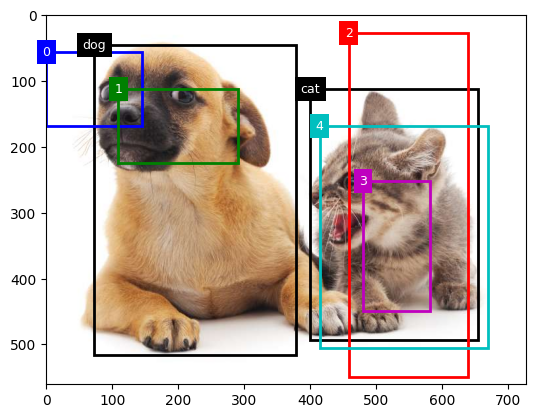

In [14]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])

fig = plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4'])


In [15]:
labels = multibox_target(anchors.unsqueeze(dim=0),
                         ground_truth.unsqueeze(dim=0))


In [16]:
labels[2]


tensor([[0, 1, 2, 0, 2]])

In [17]:
labels[1]


tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
         1., 1.]])

In [18]:
labels[0]


tensor([[-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,  1.4000e+00,
          1.0000e+01,  2.5940e+00,  7.1754e+00, -1.2000e+00,  2.6882e-01,
          1.6824e+00, -1.5655e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -5.7143e-01, -1.0000e+00,  4.1723e-06,  6.2582e-01]])

In [19]:
def offset_inverse(anchors,offset_preds):
    anc = box_center_to_corner(anchors)
    pred_bbox_xy = (offset_preds[:,:2] * anc[:,2:]/10) +anchors[:,:2]
    pred_bbox_wh = torch.exp(offset_preds[:2:]/5)*anc[:,2:]
    pred_bbox = torch.cat((pred_bbox_xy,pred_bbox_wh),dim=1)
    predicted_bbox = box_center_to_corner(pred_bbox)

    return predicted_bbox

In [20]:
def nms(boxes,scores,iou_threshold):
    B = torch.argsort(scores,dim=-1,descending=True)
    keep = []
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1:
            break
        iou = box_iou(boxes[i,:].reshape(-1,4),
                      boxes[B[1:],:].reshape(-1,4)).reshape(-1)

        inds = torch.nonzero(iou<=iou_threshold).reshape(-1)
        
        B = B[inds + 1]

    return torch.tensor(keep,device=boxes.device)

In [ ]:
def multibox_detection(cls_probs,
                       offset_preds,
                       anchors,
                       nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """
    cls_probs 为概率矩阵shape为(batch_size,classes,num_anchors)
    offset_preds 为预测的偏移量
    anchor 为锚框
    
    """
    device , batch_size =  cls_probs.device,cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes,num_anchors = cls_probs.shape[1],cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob , offset_pred = cls_probs[i],offset_preds[i]
        #先提取出概率预测和偏移预测的矩阵
        conf , class_id = torch.max(cls_prob[1:],0)
        #然后在dim=0上作一次置信度提取
        predicted_bb = offset_inverse(anchors,offset_pred)
        #转化为对应的预测框
        keep = nms(predicted_bb,conf,nms_threshold)
        #通过预测框和置信度来获得最合理的框的数据
        all_idx = torch.arange(num_anchors,
                               dtype=torch.long,
                               device=device)
        combined = torch.cat((keep,all_idx))
        #合并
        uniques, counts = combined.unique(return_counts=True)
        #获得独一的数据以及出现的次数
        non_keep = uniques[counts == 1]
        #筛选不可信的
        all_id_sorted = torch.cat((keep, non_keep))
        #拼接实现顺序
        class_id[non_keep] = -1
        #将不可信的设为背景
        class_id = class_id[all_id_sorted]
        #转化顺序
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        # pos_threshold是一个用于非背景预测的阈值
        below_min_idx = (conf < pos_threshold)
        #提取置信度低的bool掩码
        class_id[below_min_idx] = -1
        #再次将置信度低的设为背景
        conf[below_min_idx] = 1 - conf[below_min_idx]
        #转化为预测背景的概率
        pred_info = torch.cat((class_id.unsqueeze(1),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)